# Etape 1 - Exploration des données (y compris préprocessing)

In [1]:
# Import librairies
import csv
import pandas as pd
import nltk
import numpy as np
import pyLDAvis
import pyLDAvis.sklearn
import warnings


from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from utils_text_processing import *

c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\tensorflow_hub\__init__.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\tensorflow_hub\__init__.py:75: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(required_tensorflow_version)):
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\yellowbrick\style\colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packa

gensim version: 4.3.0
tensorflow version: 2.10.0
Num GPUs Available:  0
is tf built with cuda: False


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


USE model %s loaded


In [2]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# Autorisation pour la visualisation par pyLDAvis
pyLDAvis.enable_notebook()

In [4]:
# Paramètres graphiques
%matplotlib inline
rc = {
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(font='Arial', rc=rc)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': True,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })
sns.set_context(
    "notebook",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})

pd.set_option('display.max_columns', None)
dpi = 300

In [5]:
# Import des données
#data = pd.read_csv("../data/export.dsv", sep="\t", encoding='latin-1')

In [6]:
# Import des données
with open('../data/export.dsv', 'r', newline='', encoding="latin") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t',)
    data=list(csv_reader) 

In [7]:
# Verification du format des données
df = pd.DataFrame(data[1:], columns=data[0]+["A", "B"])
print(f"le Fichier de données contient {df.shape[0]} lignes et  {df.shape[1]} colonnes")

le Fichier de données contient 89434 lignes et  7 colonnes


In [8]:
# Visualisation
df.head()

,PPN,TITRE,RESUME,RAMEAU,DEWEY,A,B
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,None,None
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63,None,None
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,None,None
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,None,None
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,None,None


In [9]:
# Recherche des lignes mal formattées
data_to_check = df[(~df["A"].isna()) | (~df["B"].isna())]
print("Nombre d'ouvrages avec soucis d'importation :", data_to_check.shape)
data_to_check

Nombre d'ouvrages avec soucis d'importation : (18, 7)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,A,B
12634,130654965,L'individu contre l'État,"La 4e de couverture indique :""","a Herbert Spencer (1820-1903), philosophe, éco...",Libéralisme;Libéralisme,320.510 941,None
14569,145536599,Thèbes aux 101 portes : mélanges à la mémoire ...,La nécropole thébaine attire archéologues et a...,architecture des chapelles funéraires et de le...,"arrêt sur images"", abordant par ailleurs la co...",Religion égyptienne;Religions;Égyptien ancien ...,932-933
20334,168619016,Le Paris des années 1920 : avec Kiki de Montpa...,"Paris, 1918-1928, ce sont les années folles. I...",avant- garde. Dadaïstes et surréalistes s'y di...,Artistes;Artistes et modèles;Vie intellectuell...,700,None
20654,169298116,La salope éthique : guide pratique pour des r...,,"a En 1997, un objet littéraire non identifié e...",Amour libre;Liberté sexuelle;Relations amoureuses,306.7,None
32591,193458209,Principes de marketing,"La quatrième de couv. indique : ""Écrit par les...",version française : des modules d'apprentissa...,Marketing,658.8,None
32974,193928604,Japanese,Guide de conversation Japonais pour anglophones,tous niveaux Quelques jours à Tokyo ou sur un...,Japonais (langue) -- Vocabulaires et manuels d...,495.683 441,None
32975,193928612,German,Guide de conversation allemand pour anglophones,tous niveaux. Berlin Munich ou peut-être Vien...,Allemand (langue) -- Vocabulaires et manuels d...,438.34,None
33309,194347818,Macroéconomie,"La 4e de couverture indique : ""Véritable livre...","version française, lui aussi augmenté, vous a...",Macroéconomie -- Manuels d'enseignement supéri...,339,None
50885,231039786,Petites conversations sur les violences : paro...,,"a En 2018, en France, les violences répétées s...",Femmes victimes de violence -- Psychologie;Vio...,362.829 2,None
58788,23698134X,"Haute agora : [exposition, Paris, Pavillon de ...","Haute Agora, étude menée par larchitecte Jean...",Ce travail se présente comme une réponse aux t...,Christianisme et franc-maçonnerie,366.1,None


In [10]:
# Export des données à vérifier
data_to_check.to_csv("data_to_check_V2.csv", index=0, encoding="latin-1")

In [11]:
# On ne garde que les données correctement importées
df = df.drop(index = data_to_check.index)
df

,PPN,TITRE,RESUME,RAMEAU,DEWEY,A,B
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,None,None
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63,None,None
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,None,None
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,None,None
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,None,None
...,...,...,...,...,...,...,...
89429,268339252,Le sentiment d'humanité : manifeste pour une f...,"« Mon enfant, ma fille, qu'est-ce qu'e^tre hum...",Humanité;Réalisation de soi,128,None,None
89430,268363072,La saga des trois petits pois,"Trois pois, Réal, Jean-Jacques et Donald, ont ...",Aliments -- Ouvrages pour la jeunesse;Pois (lé...,843/.914 D814s,None,None
89431,268365113,Droit de la représentation du personnel,"Présentation de l'éditeur : ""Le droit de la re...",Représentation du personnel,344.018,None,None
89432,268365334,Droit pénal social : droit pénal du travail et...,"Depuis deux siècles, la conjugaison de l'essor...",Droit pénal;Sécurité sociale -- Droit -- Dispo...,345.44,None,None


In [12]:
# Verification que les colonnes A et B sont vides
print("Colonne A: ", all(df["A"].isna()))
print("Colonne B: ", all(df["B"].isna()))

Colonne A:  True
Colonne B:  True


In [13]:
# Suppression des colonnes vides
df.dropna(axis=1, inplace=True)
df.shape

(89416, 5)

In [14]:
# Echantillon de visualisation
df.head()

,PPN,TITRE,RESUME,RAMEAU,DEWEY
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830


In [15]:
# Vérification du format des colonnes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89416 entries, 0 to 89433
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PPN     89416 non-null  object
 1   TITRE   89416 non-null  object
 2   RESUME  89416 non-null  object
 3   RAMEAU  89416 non-null  object
 4   DEWEY   89416 non-null  object
dtypes: object(5)
memory usage: 4.1+ MB


## Exploration des mots-clé RAMEAU

In [16]:
df.loc[1:10, "RAMEAU"]

1             Complexe de castration;Psychanalyse;Rêves
2                                               Culture
3                                        Structuralisme
4     Science-fiction américaine -- Traductions fran...
5                                          Photographie
6     Agglomérations urbaines;Aménagement du territo...
7                     Tarots (cartes à jouer) -- Contes
8     Allégorie de la caverne;Différences entre sexe...
9     Attachement;Mères et nourrissons;Personnalité ...
10                  Philosophes;Philosophie et sciences
Name: RAMEAU, dtype: object

In [17]:
# Extraction des indices contenant " -- " dans la colonne RAMEAU
df["test_tiret"] = df["RAMEAU"].apply(lambda x: True if re.search(' -- ', x) else False)
df.loc[df["test_tiret"]==True, ["PPN", "RAMEAU"]]

,PPN,RAMEAU
4,000026352,Science-fiction américaine -- Traductions fran...
7,000039470,Tarots (cartes à jouer) -- Contes
9,000041416,Attachement;Mères et nourrissons;Personnalité ...
11,000049719,Civilisation -- Histoire
18,000062995,Professeurs des écoles -- Formation;Écoles nor...
...,...,...
89420,268319014,Art chrétien -- Peinture
89423,268334846,Préparation au mariage -- Église catholique
89430,268363072,Aliments -- Ouvrages pour la jeunesse;Pois (lé...
89432,268365334,Droit pénal;Sécurité sociale -- Droit -- Dispo...


In [18]:
df["rameau_list"] = df["RAMEAU"].apply(lambda x: x.split(';')).apply(lambda x: ",".join(set(x)))
df.loc[1:10, "rameau_list"]

1             Psychanalyse,Rêves,Complexe de castration
2                                               Culture
3                                        Structuralisme
4     Science-fiction américaine -- Traductions fran...
5                                          Photographie
6     Aménagement du territoire,Relations villes-cam...
7                     Tarots (cartes à jouer) -- Contes
8     Différences entre sexes (psychologie),Allégori...
9     Mères et nourrissons,Personnalité -- Chez l'en...
10                  Philosophie et sciences,Philosophes
Name: rameau_list, dtype: object

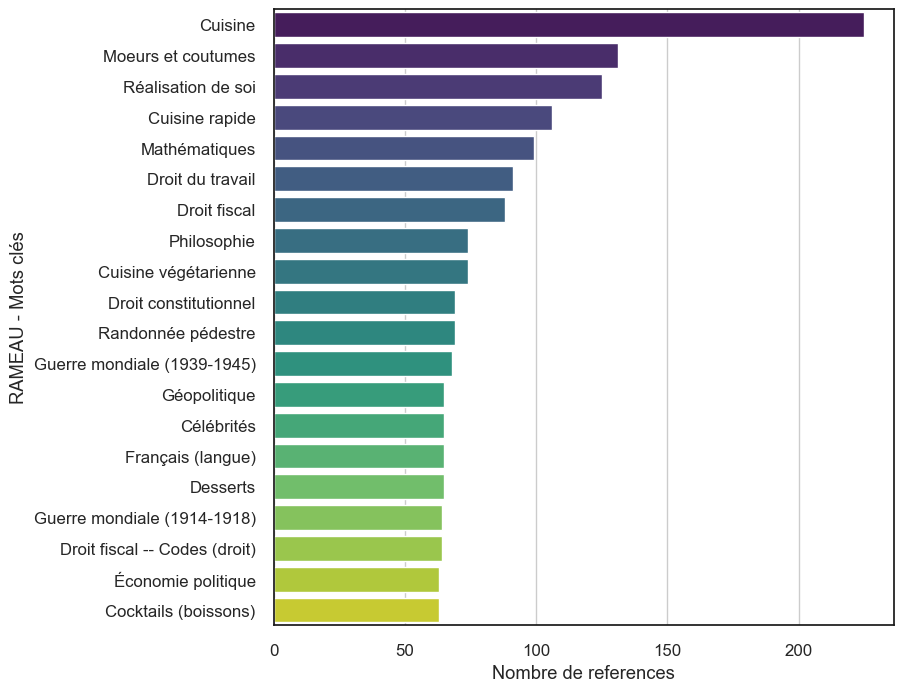

In [19]:
plot_barplot_of_tags(
    tags_list=df.loc[:, 'rameau_list'],
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Mots clés",
    figsave='figures/barplot_Rameau_keywords.png',
    figsize=(8, 8))

In [23]:
# Mettre à plat TOUS les mots clé
for i in df.index:
    ram_list = df.loc[i, "rameau_list"]
    if re.search(" -- ", ram_list):
        df.loc[i, "rameau_list_concepts_majeurs"] = ",".join([item.split(" -- ")[0] for item in ram_list.split(",")])
    else:
        df.loc[i, "rameau_list_concepts_majeurs"] = ram_list

In [24]:
df["rameau_list_concepts_majeurs"] 

0        Politique culturelle,Diffusion de la culture,C...
1                Psychanalyse,Rêves,Complexe de castration
2                                                  Culture
3                                           Structuralisme
4                               Science-fiction américaine
                               ...                        
89429                          Humanité,Réalisation de soi
89430                              Pois (légumes),Aliments
89431                          Représentation du personnel
89432                         Droit pénal,Sécurité sociale
89433                         Fraude scientifique,Médecins
Name: rameau_list_concepts_majeurs, Length: 89416, dtype: object

In [34]:
concepts = df['rameau_list_concepts_majeurs'].value_counts().to_dict()
concepts

{'Français (langue)': 319,
 'Cuisine': 261,
 'Mathématiques': 213,
 'Droit fiscal': 178,
 'Moeurs et coutumes': 175,
 'Guerre mondiale (1914-1918)': 162,
 'Réalisation de soi': 155,
 'Guerre mondiale (1939-1945)': 153,
 'Anglais (langue)': 130,
 'Droit du travail': 129,
 'Football': 125,
 'Philosophie': 117,
 'Art': 107,
 'Cuisine rapide': 106,
 'Droit constitutionnel': 100,
 'Célébrités': 97,
 'Institutions politiques,Droit constitutionnel': 93,
 'Architecture': 89,
 'Femmes': 88,
 'Animaux': 87,
 'Peinture': 87,
 'Photographie': 86,
 'Économie politique': 80,
 'Obligations (droit)': 76,
 'Randonnée pédestre': 76,
 'Culture générale': 75,
 'Cuisine végétarienne': 75,
 'Psychanalyse': 69,
 'Desserts': 68,
 'Géopolitique': 68,
 'Physique': 68,
 'Droit pénal': 66,
 'Dinosaures': 64,
 'Cocktails (boissons)': 63,
 'Droit': 63,
 'Politique et gouvernement': 62,
 'Sports': 62,
 'Hatha-yoga': 61,
 'Sciences': 60,
 'Droit international': 60,
 'Direction du personnel,Ressources humaines': 60,
 

In [35]:
len(concepts)

55036

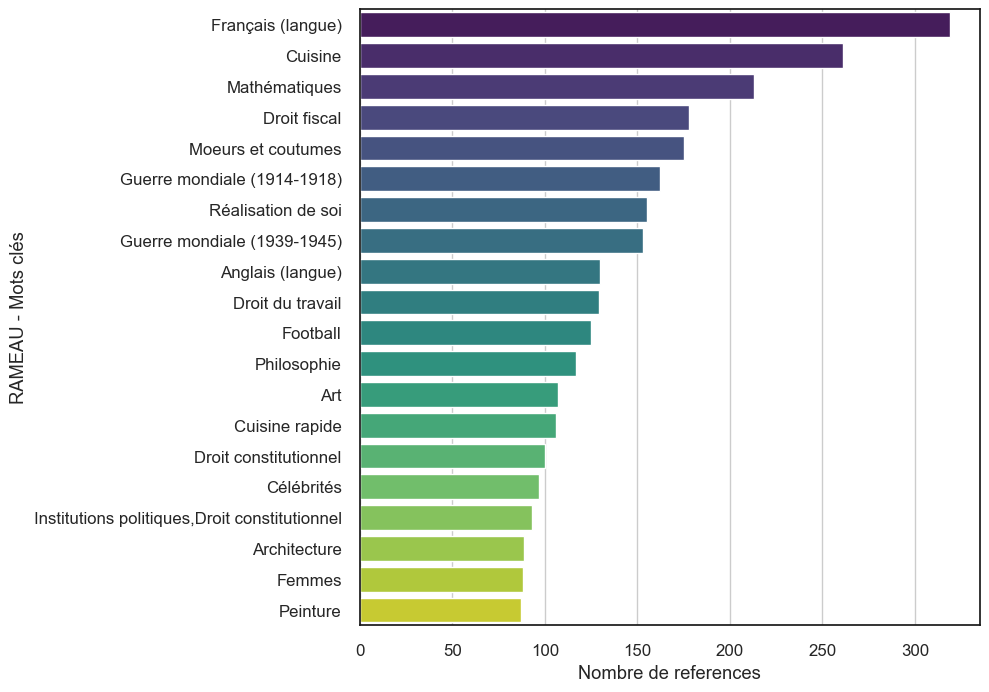

In [25]:
plot_barplot_of_tags(
    tags_list=df.loc[:, 'rameau_list_concepts_majeurs'],
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Mots clés",
    figsave='figures/barplot_Rameau_mainConcepts_keywords.png',
    figsize=(8, 8))

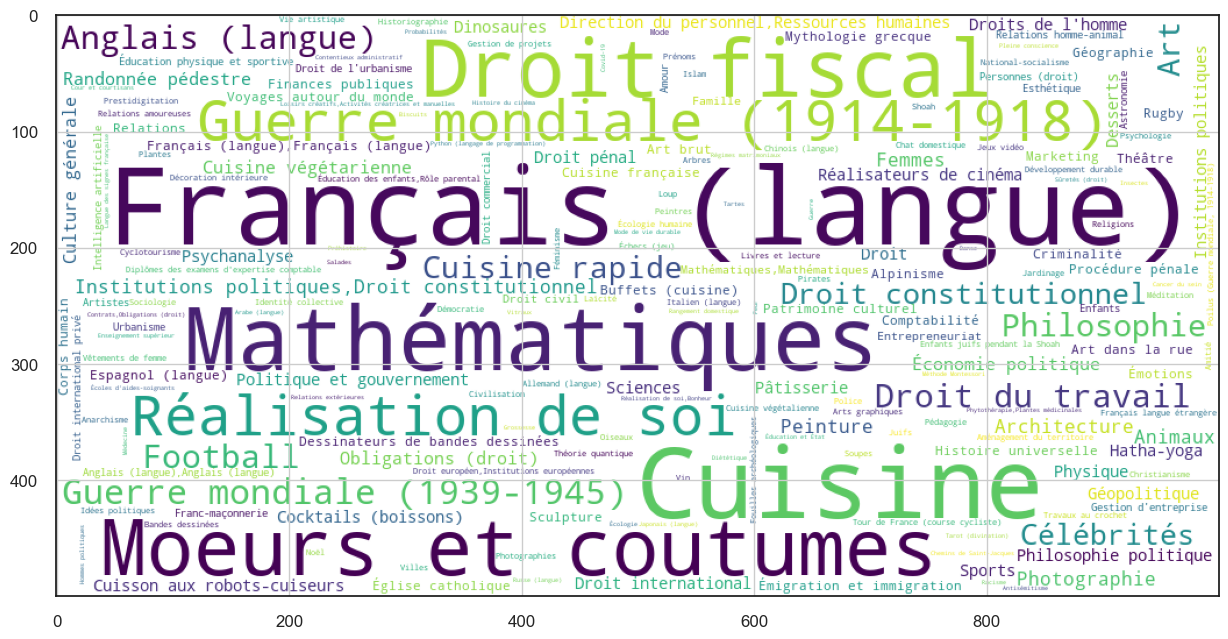

In [26]:
rameau_list_concepts_majeurs_dict = df['rameau_list_concepts_majeurs'].value_counts().to_dict()
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(rameau_list_concepts_majeurs_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

In [27]:
# Mettre à plat TOUS les mots clé
df["rameau_list_unstack"] = df["RAMEAU"].apply(lambda x: re.split(r';| -- ', x)).apply(lambda x: ", ".join(set(x)))
df.loc[1:10, "rameau_list_unstack"]

1           Psychanalyse, Rêves, Complexe de castration
2                                               Culture
3                                        Structuralisme
4     Science-fiction américaine, Traductions frança...
5                                          Photographie
6     Aménagement du territoire, Relations villes-ca...
7                       Tarots (cartes à jouer), Contes
8     Différences entre sexes (psychologie), Allégor...
9     Mères et nourrissons, Chez l'enfant, Attacheme...
10                 Philosophie et sciences, Philosophes
Name: rameau_list_unstack, dtype: object

In [31]:
keywords = df['rameau_list_unstack'].value_counts().to_dict()
keywords

{'Cuisine': 225,
 'Moeurs et coutumes': 131,
 'Réalisation de soi': 125,
 'Cuisine rapide': 106,
 'Mathématiques': 99,
 'Droit du travail': 91,
 'Droit fiscal': 88,
 'Philosophie': 74,
 'Cuisine végétarienne': 74,
 'Guerre mondiale (1939-1945)': 69,
 'Randonnée pédestre': 69,
 'Droit constitutionnel': 69,
 'Français (langue)': 66,
 'Célébrités': 65,
 'Desserts': 65,
 'Géopolitique': 65,
 'Guerre mondiale (1914-1918)': 64,
 'Droit fiscal, Codes (droit)': 64,
 'Cocktails (boissons)': 63,
 'Économie politique': 63,
 'Institutions politiques, Droit constitutionnel': 61,
 'Cuisson aux robots-cuiseurs': 59,
 'Peinture': 58,
 'Hatha-yoga': 58,
 'Direction du personnel, Ressources humaines': 57,
 'Art': 53,
 'Dinosaures': 52,
 'Psychanalyse': 52,
 'Photographie': 52,
 'Pâtisserie': 51,
 'Obligations (droit)': 49,
 'Culture générale': 49,
 'Philosophie politique': 48,
 'Cuisine française': 48,
 'Dessinateurs de bandes dessinées': 46,
 'Alpinisme': 46,
 'Buffets (cuisine)': 45,
 'Femmes': 45,
 '

In [32]:
len(keywords)

62673

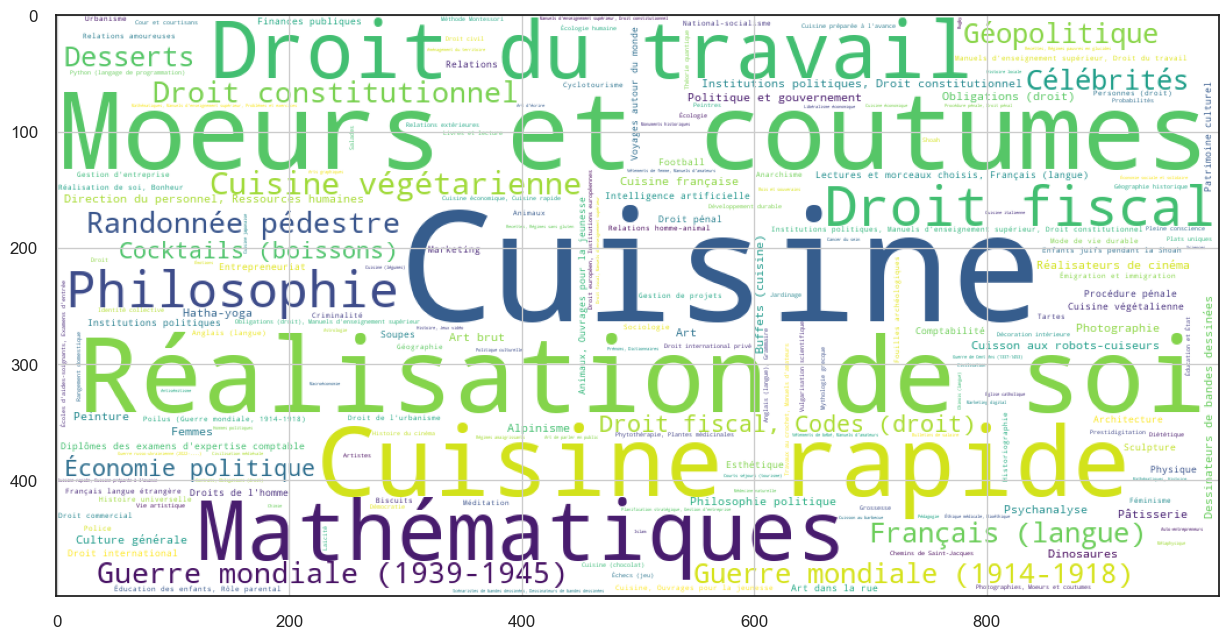

In [33]:
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(keywords)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

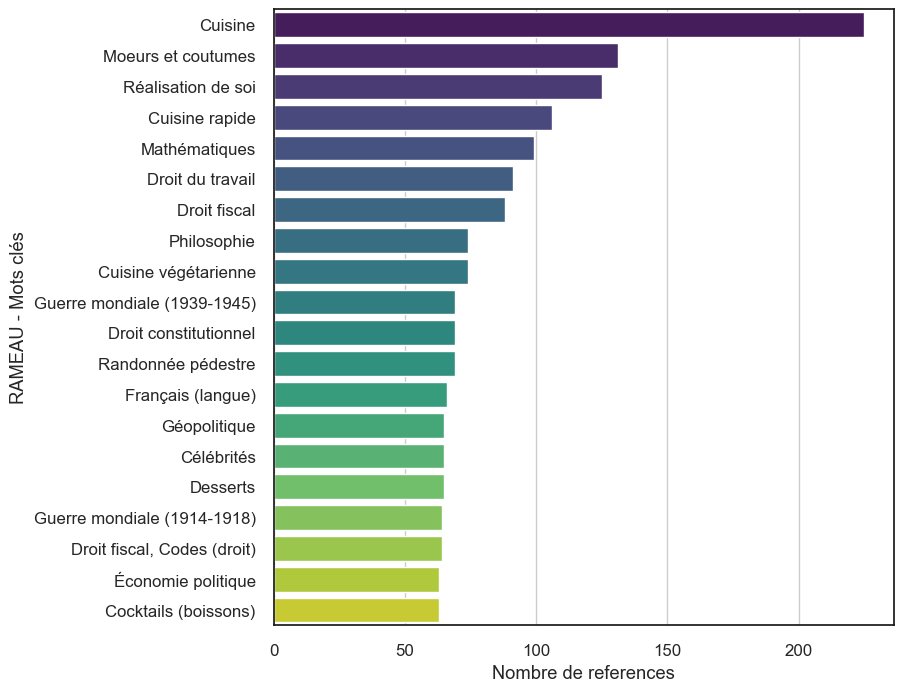

In [30]:
plot_barplot_of_tags(
    tags_list=df.loc[:, 'rameau_list_unstack'],
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Mots clés",
    figsave='figures/barplot_Rameau_keywords_unstack.png',
    figsize=(8, 8))

## Exploration des titres

In [36]:
list(set(stopwords.words("french")))

['la',
 'ayantes',
 'ayant',
 'eue',
 'aurions',
 'ton',
 'était',
 'étantes',
 'm',
 'nos',
 'toi',
 'étée',
 'serions',
 'pour',
 'eûmes',
 'soit',
 's',
 'seront',
 'eux',
 'votre',
 'auraient',
 'notre',
 'aurait',
 'qui',
 'sommes',
 'eut',
 'je',
 'ou',
 'j',
 'auront',
 'ont',
 'il',
 'tes',
 'vos',
 'avais',
 'avait',
 'eus',
 'mon',
 'aura',
 'furent',
 'et',
 'l',
 'te',
 'nous',
 'étante',
 'aient',
 'auras',
 'sera',
 'fût',
 'fus',
 'une',
 'fussent',
 'fûmes',
 'étant',
 'aviez',
 'y',
 'soyons',
 'son',
 'fusse',
 'avons',
 'avaient',
 'serais',
 'me',
 'sont',
 'serons',
 'sa',
 'se',
 'de',
 'eusses',
 'ne',
 'été',
 'ayants',
 'leur',
 'que',
 'eussiez',
 'ayons',
 'ai',
 'ait',
 'un',
 'par',
 'soient',
 'seras',
 'est',
 'avec',
 'pas',
 'du',
 'les',
 'étés',
 'fusses',
 'aurais',
 'lui',
 'tu',
 'eues',
 'fut',
 'avions',
 'eûtes',
 'eu',
 'soyez',
 'mes',
 'fussiez',
 'étiez',
 'eût',
 'seriez',
 'même',
 'ses',
 'ces',
 'qu',
 'eusse',
 'elle',
 'ma',
 'vous',
 

In [37]:
# Test function
idx = 1045
text = df.loc[idx, 'TITRE']
print(text)

Éloge de la folie : Adages : Colloques : Réflexions sur l'éducation, la religion, la guerre, la philosophie


In [38]:
# add words
add_words = [
        "la",
        "de",
        "le",
        "les",
        "l",
        "au",
        "du"
]


preprocess_text(
        text, add_words,
        numeric=True, stopw=True,
        stem=False, lem=True)

'éloge folie adage colloques réflexions éducation religion guerre philosophie'

In [39]:
idx = 65748
df['TITRE_processed'] = df['TITRE'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

# Exemple
print("Titre brut: \n", df.loc[idx, 'TITRE'])
print("\nTitre après processing :\n", df.loc[idx, 'TITRE_processed'])

Titre brut: 
 Séminaire Bourbaki : [avec table par noms d'auteurs de 1948/49 à 2017/18]

Titre après processing :
 séminaire bourbaki table noms auteur 1948 49 2017 18


In [40]:
idx = 3473
df['TITRE_processed'] = df['TITRE'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

# Exemple
print("Titre brut: \n", df.loc[idx, 'TITRE'])
print("\nTitre après processing :\n", df.loc[idx, 'TITRE_processed'])

Titre brut: 
 Et si on faisait payer les étrangers ? : Louis XIV, les immigrés et quelques autres

Titre après processing :
 si faisait payer étrangers louis xiv immigrés quelques autres


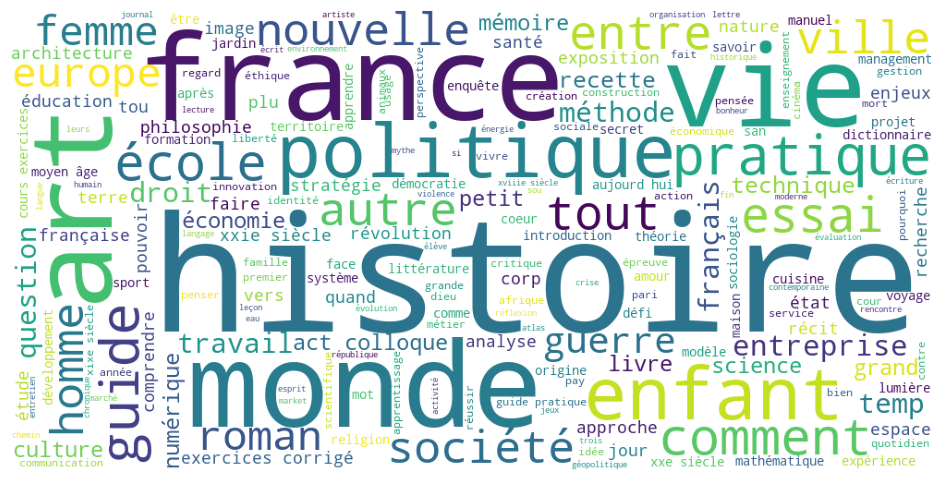

In [41]:
plot_wordcloud(df['TITRE_processed'])

### Exploration des topics (pyLDAvis)

In [70]:
# Vectorization
feature = 'TITRE_processed'
model = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 3),
    min_df=10,
    max_df=0.95)
cv_transform = model.fit_transform(df[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (89416, 100)


In [71]:
# Reduction dimension
n_comp = 15
lda = LatentDirichletAllocation(
    n_components=n_comp,
    learning_method='online',
    random_state=42
    )
x_red = lda.fit_transform(cv_transform)

In [72]:
p = pyLDAvis.sklearn.prepare(lda, cv_transform, model)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.320280  0.004173       1        1  14.354299
6     -0.069155 -0.133456       2        1   7.790167
2     -0.063063  0.434312       3        1   7.162736
5     -0.066931  0.113035       4        1   7.160589
11     0.328559  0.012941       5        1   6.963098
14    -0.060885 -0.061008       6        1   6.625932
10    -0.060619 -0.060890       7        1   6.457468
12    -0.056734 -0.046565       8        1   6.323636
1     -0.057224 -0.023343       9        1   6.316043
9     -0.056122 -0.046908      10        1   6.026246
8     -0.047511 -0.039317      11        1   5.828749
7     -0.032207 -0.041419      12        1   4.895238
4     -0.032641 -0.038108      13        1   4.831196
13    -0.025567 -0.035905      14        1   4.710132
3     -0.020180 -0.037541      15        1   4.554470, topic_info=        Term         Freq        Total Category  logprob  loglift
47  histoire  2584.000000  2584.000000  Default  30.0000  30.0000
82    siècle  1914.000000  1914.000000  Default  29.0000  29.0000
24     droit  2034.000000  2034.000000  Default  28.0000  28.0000
91       vie  1537.000000  1537.000000  Default  27.0000  27.0000
46     guide  1441.000000  1441.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
89   travail     0.105176   533.854229  Topic15 -10.2135  -5.4432
44     grand     0.105176   919.326923  Topic15 -10.2135  -5.9867
70  pratique     0.105176   879.733512  Topic15 -10.2135  -5.9427
24     droit     0.105176  2034.517780  Topic15 -10.2135  -6.7811
55    manuel     0.105176   523.338894  Topic15 -10.2135  -5.4233

[682 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0        10  0.997664        100
1        14  0.997320       2017
2        14  0.998422       2018
3         1  0.997368       2019
4         9  0.998690         50
...     ...       ...        ...
95       11  0.998688      école
96        4  0.997483   économie
97        3  0.997730  éducation
98        1  0.997448       état
99        6  0.998294       être

[101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 3, 6, 12, 15, 11, 13, 2, 10, 9, 8, 5, 14, 4])

In [73]:
pyLDAvis.save_html(p, "pyldavis_titres.html")

## Exploration des résumés

In [74]:
idx = 4998
df['RESUME_processed'] = df['RESUME'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

# Exemple
print("Résumé brut: \n", df.loc[idx, 'RESUME'])
print("\nRésumé après processing :\n", df.loc[idx, 'RESUME_processed'])

Résumé brut: 
 La 4e de couverture indique : "Le nom d'Haussmann (1809-1891) reste indéfectiblement lié à Paris. Au cours du siècle écoulé, les biographes se sont bousculés et les exégètes à leur suite : ils n'ont pas fini de se disputer la ville que le " grand homme " du second Empire nous a léguée. Haussmann au crible n'a pas pour ambition de retracer, pas à pas, l'existence d'un octogénaire qui ne semble avoir vécu pleinement que les dix-sept années de sa magistrature parisienne, et qui, pour le reste, se conduisit en parfait décalage avec l'image qu'il a laissée de lui-même. Ce livre est le fruit d'un exceptionnel travail d'enquête, son auteur ayant eu accès à des archives jamais consultées auparavant qui contestent au " préfet éventreur " la paternité d'un urbanisme que son nom même désigne. Nicolas Chaudun passe une uvre au crible et, ce faisant, s'interroge sur la nature de son créateur : bienfaiteur ou fléau, Haussmann fait figure de pionnier, de météore ; il pourrait tut auss

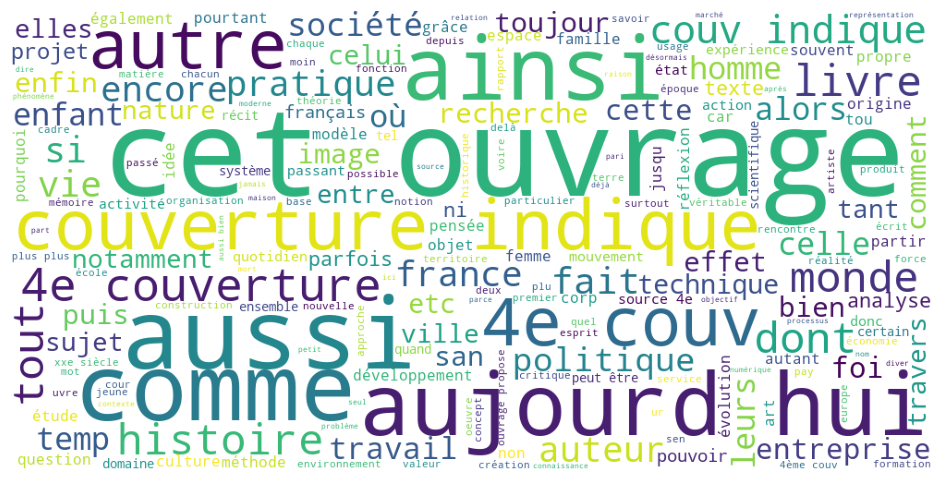

In [75]:
plot_wordcloud(df['RESUME_processed'])

In [76]:
# Vectorization
feature = 'RESUME_processed'
model = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 5),
    min_df=10,
    max_df=0.95)
cv_transform = model.fit_transform(df[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (89416, 300)


In [77]:
# Reduction dimension
n_comp = 15
lda = LatentDirichletAllocation(
    n_components=n_comp,
    learning_method='online',
    random_state=42
    )
x_red = lda.fit_transform(cv_transform)

In [78]:
p = pyLDAvis.sklearn.prepare(lda, cv_transform, model)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.068460  0.006063       1        1  10.511361
2      0.059792 -0.043129       2        1  10.021157
3      0.084928 -0.055803       3        1   9.319817
1      0.059120 -0.016617       4        1   8.452858
9      0.080590  0.054324       5        1   8.107580
6      0.098712 -0.062182       6        1   7.877238
5      0.065810 -0.002888       7        1   7.739425
4      0.092031  0.014255       8        1   7.196044
14     0.095956 -0.065131       9        1   6.574242
13     0.082366  0.000685      10        1   6.034845
7      0.087342 -0.047270      11        1   5.902388
10     0.057712 -0.020911      12        1   5.394805
8     -0.093336  0.384126      13        1   3.402438
12    -0.390230 -0.160451      14        1   1.749906
0     -0.449253  0.014930      15        1   1.715897, topic_info=          Term         Freq        Total Category  logprob  loglift
87     enfants  3029.000000  3029.000000  Default  30.0000  30.0000
86      enfant  2907.000000  2907.000000  Default  29.0000  29.0000
160        mot  2203.000000  2203.000000  Default  28.0000  28.0000
194      petit  2118.000000  2118.000000  Default  27.0000  27.0000
59        couv  2179.000000  2179.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
89      enjeux     0.214320   907.862672  Topic15 -10.2691  -4.2861
258    société     0.214319  1267.869303  Topic15 -10.2691  -4.6201
209   pourtant     0.214319   811.623762  Topic15 -10.2691  -4.1741
199   physique     0.214319   672.442680  Topic15 -10.2691  -3.9860
297  étudiants     0.214319   929.484828  Topic15 -10.2691  -4.3097

[674 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.052596    4e
0         3  0.000768    4e
0         4  0.032248    4e
0         5  0.371624    4e
0         7  0.015740    4e
...     ...       ...   ...
299       8  0.067981  être
299       9  0.032269  être
299      11  0.050340  être
299      12  0.100250  être
299      15  0.003442  être

[2613 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 3, 4, 2, 10, 7, 6, 5, 15, 14, 8, 11, 9, 13, 1])

In [79]:
pyLDAvis.save_html(p, "pyldavis_resumes.html")